<a href="https://colab.research.google.com/github/khodid/2020_SAI_MONING2/blob/master/How_to_use_custom_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습일: 2020.05.23

내가 원하는 이미지 데이터를 불러와서 Classification 학습을 시키는 과정을 배워 보겠다.

In [207]:
# 내가 가져온 이미지 학습시키려고...
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# 데이터셋 준비하기

절차: 

1. 학습시키고자 하는 이미지를 최대한 시각적으로 뚜렷이 구분되는 것으로 다수 준비한다.

2. 파일을 정답 분류별로 나누어서 저장한다.

\여기에 파일 저장 방법 이미지로.

## Size 낮추기

In [0]:
# 패키지 불러오기
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader

In [0]:
from matplotlib.pyplot import imshow
%matplotlib inline

 이미지 파일의 크기를 조정하는 것은 transforms 패키지를 활용한다.

In [0]:
trans = transforms.Compose([
  transforms.Resize([64, 128]) # 높이 64, 너비 120
])

In [0]:
project_path = '/content/gdrive/My Drive/Colab Notebooks/CNN_practice/first_trial/original_data'
train_data = torchvision.datasets.ImageFolder(root = project_path , transform=trans)
# 이미지 파일을 저장한 디렉토리로 root을 설정해준다.
# 위에 설정한 transforms를 인자로 넣어 준다.

custom_data 폴더에 train\_data 폴더를 생성해 준 후 아래 코드를 실행한다.

In [0]:
for num, value in enumerate(train_data):
  data, label = value
  #print(num, data, label)
  
  ## 이미지 업로드 확인용 코드.
  #imshow(data)
  #break


if(label == 0):
  data.save('/content/gdrive/My Drive/Colab Notebooks/CNN_practice/first_trial/train_data/baby/%d_%d.jpeg'%(num,label))
else:
  data.save('/content/gdrive/My Drive/Colab Notebooks/CNN_practice/first_trial/train_data/food/%d_%d.jpeg'%(num,label))


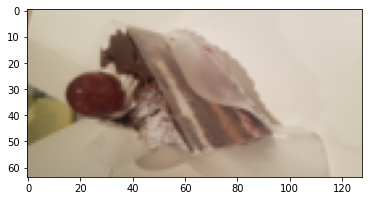

In [159]:
imshow(data)

# Neural Network 만들기

구조는 강의에서 제시하는 걸 그대로 따라할 생각이다.

**input data**는 channel = 3, height = 64, width = 128

**layer1,2**에는 conv2d, ReLU, MaxPool

**layer 3**에는 view FC(Fully Connected)1, ReLU, FC2

**loss 계산**은 분류 문제이므로 Cross Entropy Loss로 하겠다.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [0]:
# GPU 환경 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manuual_seed_all(777)

In [0]:
trans= transforms.Compose([
                              transforms.Resize([64, 128]), # 높이 64, 너비 120
                              transforms.ToTensor()
])

train_path ='/content/gdrive/My Drive/Colab Notebooks/CNN_practice/first_trial/original_data'
# 여기서 원래는 resize도 할 필요 없고(방금전 traindata 만드는 곳에서 했으니깐...)
# path도 /train_data였어야 했는데
# gdrive 호환 문제인지 뭔지, 알기 힘든 원인에 의해 이미지가 단 하나씩만 로드되는 것 같아서
# 원활한 학습을 위해 그냥 original data에서 바로 변형해서 쓰기로 함.
train_data = torchvision.datasets.ImageFolder(root =train_path, transform = trans)

In [0]:
data_loader = DataLoader(dataset=train_data, batch_size = 8, shuffle = True, num_workers=2)

112


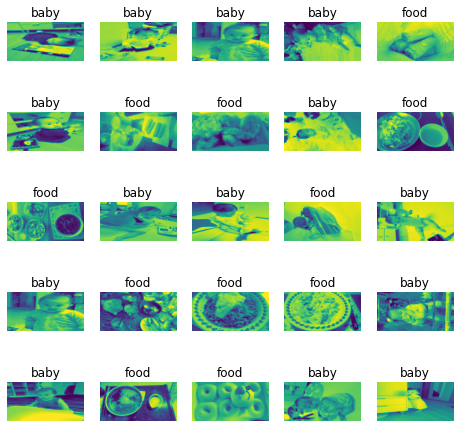

In [184]:
import matplotlib.pyplot as plt
import numpy as np
labels_map = {0 :'baby', 1 : 'food'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

print(len(train_data))
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img)
    plt.axis('off')
plt.show()

 **모델을 변경해주거나 선언할 때 size를 확인해주는 팁**으로, 아래 주석에 달아놓을 것과 같이, forward 쪽에서 데이터가 layer에 들어가고 나올 때마다 print(out.shape)를 해주고 테스트 데이터(빈 텐서)를 넣어보면 각 레이어 별 output의 크기를 확인해줄 수 있다.

 확인 작업이 끝났을 경우에는 print를 없애거나 주석처리 해주어야 한다.


In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 6, 5),  ##입력채널 6개,출력채널 6개, 필터 size 5. stride = default(=1)
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer3 = nn.Sequential(
        nn.Linear(16*13*29, 120),
        nn.ReLU(),
        nn.Linear(120, 2)
    )
  def forward(self, x):
    out = self.layer1(x)
    #print(out.shape) 
    out = self.layer2(out)
    #print(out.shape)
    out = out.view(out.shape[0], -1)
    #print(out.shape)
    out = self.layer3(out)
    return out

In [0]:
# 모델의 input, output size 잘 맞춰줬는지 확인
net = CNN().to(device)
test_input = (torch.Tensor(3, 3, 64, 128)).to(device)
test_out = net(test_input)

In [0]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)

In [191]:
total_batch = len(data_loader)
epochs = 30
for epoch in range(epochs):
  arg_cost = 0.0
  for num, data  in enumerate(data_loader):
    imgs, labels = data
    imgs = imgs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    
    out = net(imgs)
    cost = criterion(out, labels)
    
    cost.backward()
    optimizer.step()

    arg_cost += cost/total_batch
  print('Epoch {} :: cost = {}'.format(epoch+1, arg_cost))
print("학습 완료.")

Epoch 1 :: cost = 0.7561425566673279
Epoch 2 :: cost = 0.6186221241950989
Epoch 3 :: cost = 0.5611521601676941
Epoch 4 :: cost = 0.3435169458389282
Epoch 5 :: cost = 0.2443326860666275
Epoch 6 :: cost = 0.16484402120113373
Epoch 7 :: cost = 0.14177078008651733
Epoch 8 :: cost = 0.12513002753257751
Epoch 9 :: cost = 0.10067744553089142
Epoch 10 :: cost = 0.06566759943962097
Epoch 11 :: cost = 0.06958584487438202
Epoch 12 :: cost = 0.05389239266514778
Epoch 13 :: cost = 0.17586971819400787
Epoch 14 :: cost = 0.12622764706611633
Epoch 15 :: cost = 0.05366179719567299
Epoch 16 :: cost = 0.02238519676029682
Epoch 17 :: cost = 0.014421283267438412
Epoch 18 :: cost = 0.00903432909399271
Epoch 19 :: cost = 0.0056082806549966335
Epoch 20 :: cost = 0.004589719697833061
Epoch 21 :: cost = 0.003952753730118275
Epoch 22 :: cost = 0.0035513273905962706
Epoch 23 :: cost = 0.0030272353906184435
Epoch 24 :: cost = 0.003626652993261814
Epoch 25 :: cost = 0.002174976747483015
Epoch 26 :: cost = 0.0020629

# 학습시킨 모델 저장하기


학습시킨 모델의 데이터를 저장하는 방법을 실습해보자.(불필요한 반복 학습을 줄여줄 수 있다.)

모델을 저장할 디렉토리를 만들기 위해,

내가 training data를 넣어줬던 파일 model을 담는 파일을 하나 더 만들어주었다. (gdrive에서 수동으로 만들어 줬음.)

In [0]:
torch.save(net.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/CNN_practice/first_trial/model/model.pth')

In [193]:
# 오브젝트(?) 선언
new_net = CNN().to(device)
# 학습된 값 불러오기.
new_net.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/CNN_practice/first_trial/model/model.pth'))

<All keys matched successfully>

In [194]:
# 내가 이전에 저장했던 그 모델이 맞는지 확인하는 코드.
print(net.layer1[0])
print(new_net.layer1[0])

print(net.layer1[0].weight[0][0][0])
print(new_net.layer1[0].weight[0][0][0])

net.layer1[0].weight[0] == new_net.layer1[0].weight[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
tensor([-0.0741,  0.0203, -0.0037, -0.0155,  0.0931], grad_fn=<SelectBackward>)
tensor([-0.0741,  0.0203, -0.0037, -0.0155,  0.0931], grad_fn=<SelectBackward>)


tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]])

# 모델 테스트 하기

In [0]:
trans = torchvision.transforms.Compose([
    transforms.Resize([64,128]),
    transforms.ToTensor()
])

test_data = torchvision.datasets.ImageFolder(root='/content/gdrive/My Drive/Colab Notebooks/CNN_practice/first_trial/test_data', transform=trans)


In [0]:
# for num, value in enumerate(test_data):
#   data, label = value
#   #print(num, data, label)
   
#   ## 이미지 업로드 확인용 코드. 위 코드블럭에서 transforms.ToTensor()를 지우고 실행한 후, 이걸 실행하면 됨.
#   imshow(data)
#   break

In [0]:
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [210]:
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        
        correct_prediction = torch.argmax(prediction, 1) == label
        
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

Accuracy: 0.8604651093482971


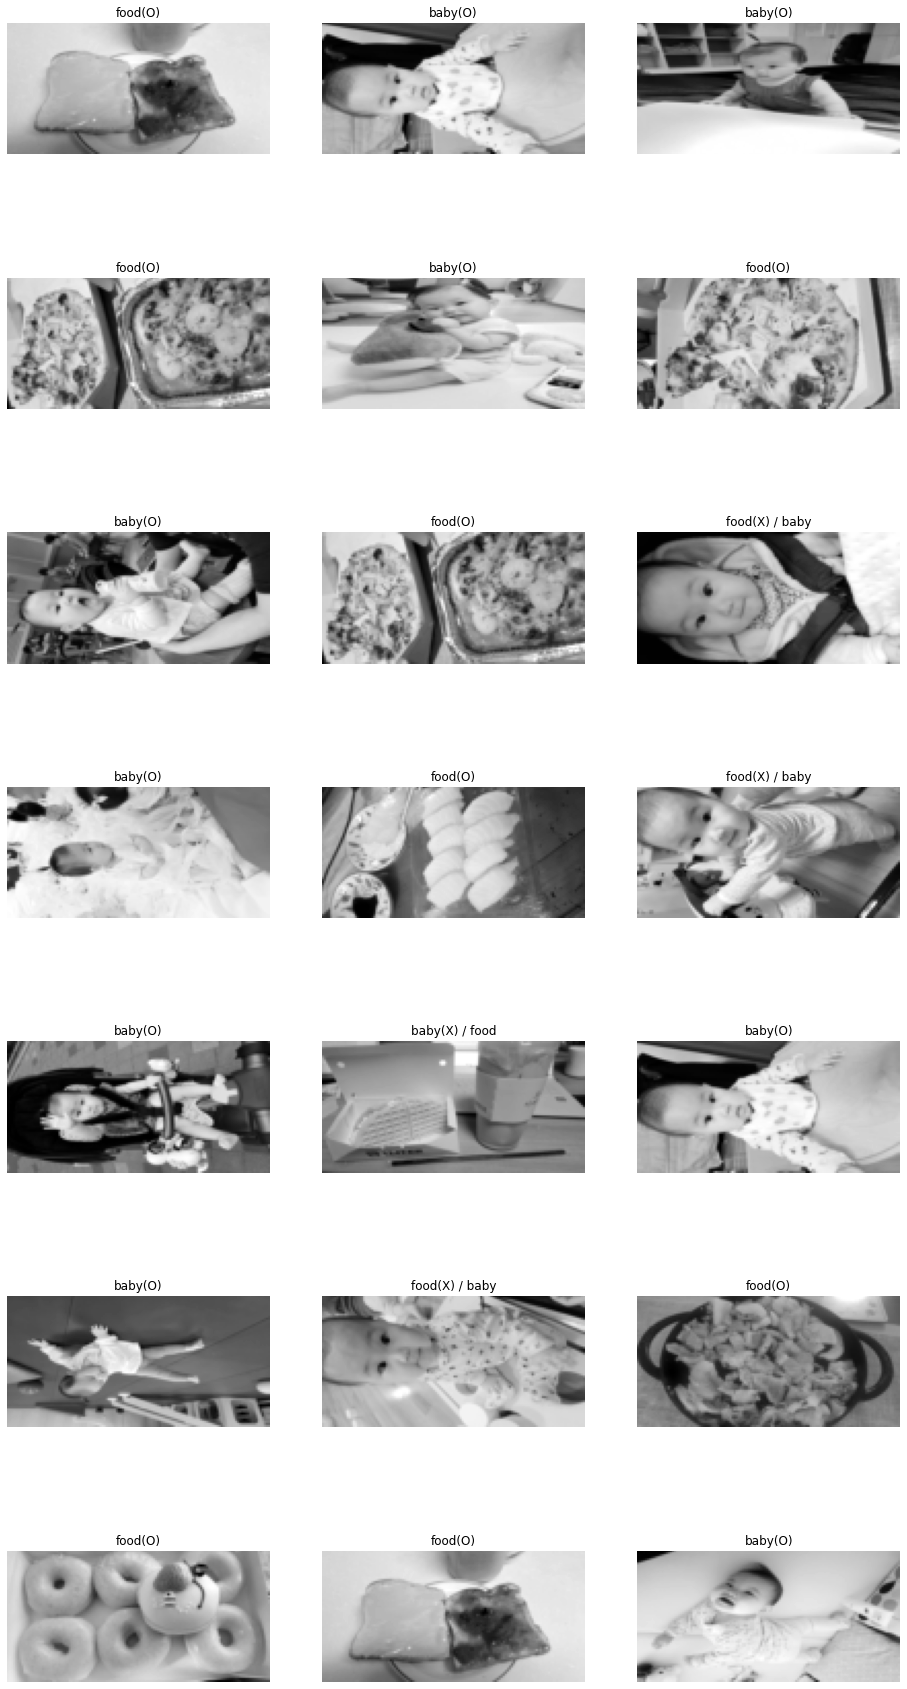

In [213]:
columns = 3
rows = 7
fig = plt.figure(figsize=(16,32))

net.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    output = net(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
net.train()
plt.show()

In [0]:
# google drive에도 업로드 성공.
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')